In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import lettuce
import lettuce as lt
from lettuce import D3Q19, Lattice, UnitConversion, BGKCollision, StandardStreaming, Simulation, IncompressibleKineticEnergy, WallQuantities, SimulationHWBB, GlobalMeanUXReporter, AdaptiveForce
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import csv

In [2]:
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter
import numpy as np
import torch

parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=100)
parser.add_argument("--tmax", type=int, default=1)
parser.add_argument("--Re", type=int, default=13800)
parser.add_argument("--collision_operator", type=str, default="Smag")
parser.add_argument("--Precision", type=str, default="Double")
parser.add_argument("--Mach", type=float, default=0.1)
parser.add_argument("--h", type=int, default=10, help="Halbe Kanalhöhe in LU")
parser.add_argument("--bbtype", type=str, default="wallfunction", choices=["halfway", "fullway", "wallfunction", "freeslip"],
                    help="Typ der Bounce-Back-Randbedingung")

args, unknown = parser.parse_known_args()
args = vars(args)

print("ICH FUNKTIONIERE MIT PULLEN")



# Einheiten und Auflösung
h = args["h"]                      # Kanalhalbhöhe in LU
res_y = 2 * h                     # y: volle Kanalhöhe
res_x = int(2*np.pi * h)
res_z = int(np.pi * h)

# Restliche Parameter
Re = args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
Precision = args["Precision"]
collision_operator = args["collision_operator"]
Mach = args["Mach"]
bbtype = args["bbtype"]
# Präzision
if Precision == "Single":
    dtype = torch.float32
elif Precision == "Double":
    dtype = torch.float64
elif Precision == "Half":
    dtype = torch.float16


Re_tau = 180

smagorinsky_constant = 0.17

delta_x = 1.0

ICH FUNKTIONIERE MIT PULLEN


In [3]:
if torch.cuda.is_available():
    device = "cuda"
    print("CUDA ist verfügbar. Verwende GPU.")
else:
    device = "cpu"
    print("CUDA ist nicht verfügbar. Verwende CPU.")

dtype = torch.float64 # Für Stabilität bei hohen Re

# --- 🧱 Lattice & Flow Initialisierung ---
# D3Q19() muss instanziiert werden. Lattice bekommt die Instanz.
lattice = Lattice(D3Q19(), device=device, dtype=dtype)

flow = lettuce.ChannelFlow3DV2(
    resolution_x=res_x,
    resolution_y=res_y,
    resolution_z=res_z,
    reynolds_number=Re, # Re_bulk
    mach_number=Mach, # Physikalische Mach-Zahl
    lattice=lattice,
    char_length_lu=res_y, # Charakteristische Länge in LU ist gesamte Höhe 2H
    boundary=bbtype # Signalisiert dem flow.boundaries, welche Boundary-Art erstellt wird
)

# --- NEUE KOMPONENTEN FÜR ADAPTIVES FORCING ---

# 1. Reporter, die die benötigten Mittelwerte liefern
# Diese Reporter müssen die Werte als zugängliche Attribute speichern (z.B. self.last_u_tau_spatial_mean)
# Stellen Sie sicher, dass Ihre WallQuantities.__call__ diese Attribute setzt.
# Beispiel für WallQuantities.__call__ Erweiterung:
# class WallQuantities(...):
#     # ...
#     def __call__(self, f):
#         # ... (alle Berechnungen von u_tau_current) ...
#         self.last_u_tau_spatial_mean = torch.mean(u_tau_current).item() # HIER HINZUFÜGEN
#         # ... return torch.zeros(4,...)

wq_bottom = WallQuantities(
    lattice=lattice, flow=flow, averaging_steps=1, # averaging_steps=1 für fast instantane Werte
    distance_to_wall=1.0, # Für Fullway BB
    smagorinsky_constant=smagorinsky_constant, delta_x=delta_x, normal_axis=1, wall='bottom'
)
wq_top = WallQuantities(
    lattice=lattice, flow=flow, averaging_steps=1, # averaging_steps=1 für fast instantane Werte
    distance_to_wall=1.0, # Für Fullway BB
    smagorinsky_constant=smagorinsky_constant, delta_x=delta_x, normal_axis=1, wall='top'
)

# Globaler Reporter für mittlere U_x über die Domäne
global_mean_ux_reporter = GlobalMeanUXReporter(lattice, flow)


# 2. AdaptiveForce Klasse initialisieren
# Sie braucht die Reporter, um die Werte zu bekommen.
# target_u_m_pu kommt aus Paper Tabelle 2: 1.0 m/s
adaptive_force_instance = AdaptiveForce(
    lattice=lattice,
    flow=flow,
    target_u_m_lu=flow.units.convert_velocity_to_lu(1.0),
    wall_quantities_bottom_reporter=wq_bottom,
    wall_quantities_top_reporter=wq_top,
    global_ux_reporter=global_mean_ux_reporter,
    base_lbm_tau_lu = flow.units.relaxation_parameter_lu
)


# --- 3. Kollisionsmodell mit dem adaptiven Forcing initialisieren ---
# Der 'force'-Parameter der SmagorinskyCollision erwartet ein Force-Objekt.
collision = lettuce.SmagorinskyCollision(lattice, tau=flow.units.relaxation_parameter_lu, force=adaptive_force_instance)


# --- Simulation Setup ---
streaming = StandardStreaming(lattice)
simulation = Simulation(flow=flow, lattice=lattice, collision=collision, streaming=streaming)


# --- 📊 Reporter zur Simulation hinzufügen ---
# Die Reporter, die als Input für AdaptiveForce dienen, MÜSSEN vor dem AdaptiveForce-Aufruf in der Simulationsschleife aktualisiert werden.
# Lettuce ruft die Reporter VOR den Boundaries und der Kollision auf, wenn sie als Simulation-Reporter hinzugefügt werden.
# Es ist wichtig, dass GlobalMeanUXReporter und WallQuantities zuerst in der Liste der Reporter stehen,
# damit ihre 'last_...' Attribute aktualisiert werden, bevor AdaptiveForce in collision(f) aufgerufen wird.
simulation.reporters.append(lt.ObservableReporter(global_mean_ux_reporter, interval=1, out=None))
simulation.reporters.append(lt.ObservableReporter(wq_bottom, interval=1, out=None))
simulation.reporters.append(lt.ObservableReporter(wq_top, interval=1, out=None))

# Andere Reporter
# Energy Reporter
simulation.reporters.append(lt.ObservableReporter(lt.observables.IncompressibleKineticEnergy(lattice, flow), interval=100, out=None))
# VTK Reporter

steps = int(flow.units.convert_time_to_lu(tmax))


vtk_reporter = lt.VTKReporter(
    lattice=lattice, flow=flow, interval=max(1,int(steps/100)), filename_base=basedir + "/output"
)
simulation.reporters.append(vtk_reporter)


# --- Simulation starten ---
# Die Methode initialize_f_neq sollte nach der Initialisierung von Lattice und Flow aufgerufen werden,
# um f mit dem initialen Geschwindigkeits- und Druckfeld zu füllen.
simulation.initialize_f_neq() # Initialisiert f in simulation.f

print(f"Starte Simulation für {steps} Schritte auf {device}...")
mlups = simulation.step(num_steps=steps)
print(f"Simulation beendet. MLUPS: {mlups}")
wq_top = np.array(simulation.reporters[2].out)
wq_bottom = np.array(simulation.reporters[1].out)
ux_mean = np.array(simulation.reporters[0].out)

with open(csvdir + 'uxmean.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(ux_mean)
with open(csvdir + 'WallQuantitiesTop.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq_top)
with open(csvdir + 'WallQuantitiesBottom.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(wq_bottom)

/home/ben/anaconda3/envs/lettuce/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392035891/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


CUDA ist nicht verfügbar. Verwende CPU.
steps     time     GlobalMeanUXReporter
steps     time     WallQuantities
steps     time     WallQuantities
steps     time     IncompressibleKineticEnergy
Starte Simulation für 346 Schritte auf cpu...
Simulation beendet. MLUPS: 1.1613024071632736


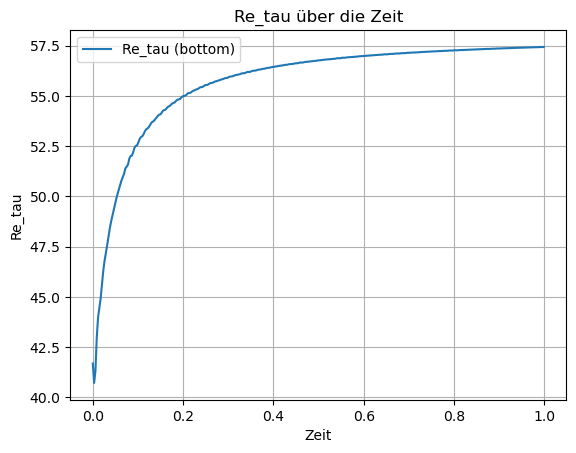

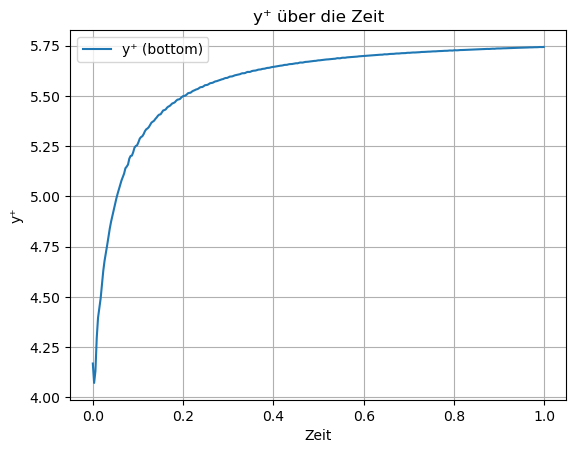

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Beispiel: Daten laden
data = (wq_bottom+wq_top)/2
time = data[:, 1]
re_tau = data[:, 2]
y_plus = data[:, 3]

plt.figure()
plt.plot(time, re_tau, label="Re_tau (bottom)")
plt.xlabel("Zeit")
plt.ylabel("Re_tau")
plt.legend()
plt.grid()
plt.title("Re_tau über die Zeit")
plt.savefig(csvdir + "retau.pdf")

plt.show()

plt.figure()
plt.plot(time, y_plus, label="y⁺ (bottom)")
plt.xlabel("Zeit")
plt.ylabel("y⁺")
plt.legend()
plt.grid()
plt.title("y⁺ über die Zeit")
plt.savefig(csvdir + "yplus.pdf")
plt.show()
